In [1]:
# %matplotlib qt6


from mavlink.mavlink import MAVLinkController, DataAcquisitionThread
from mavlink.mavlink.processor import GimbalProcessor, GlobalPositionProcessor, AttitudeProcessor


mavlink_connection = MAVLinkController("udp:0.0.0.0:14550")

attitude_processor = AttitudeProcessor()
global_position_processor = GlobalPositionProcessor()
gimbal_processor = GimbalProcessor()

acquisition_thread = DataAcquisitionThread(
    mavlink_connection, 
    [attitude_processor, global_position_processor, gimbal_processor]
)
acquisition_thread.start()

In [2]:
from data_stream import StreamReceiver
from simulation.webots.controllers.ardupilot_vehicle_controller.drone_data import DroneData



host = "192.168.0.107"
port = 5588
stream_receiver = StreamReceiver(host, port)

In [62]:
import math

latest_data = gimbal_processor.get_data()
if latest_data:
    print("GIMBAL", [math.degrees(axis) for axis in latest_data.quaternion.to_euler()])


GIMBAL [-5.560075901749916e-07, -37.487700320789266, -26.863394834068277]


In [67]:
mavlink_connection.gimbal.set_angles(
    roll=0,
    pitch=-45,
    yaw=-35
)

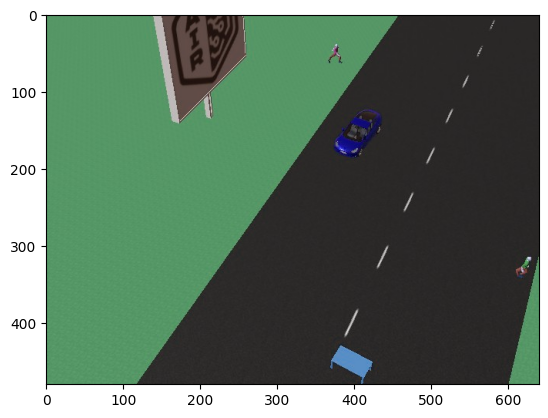

In [68]:
from matplotlib import pyplot as plt


data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

plt.imshow(camera_frame)

In [69]:
from ultralytics import YOLO
import random
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.deep_sort.deep.extractor import Extractor
from deep_sort.deep_sort.deep.configuration import ResNetConfiguration
from deep_sort.deep_sort.deep.weights import RESNET18_WEIGHTS


model = YOLO("yolov8n-visdrone.pt")

detection_threshold = 0.3

resnet = ResNetConfiguration(
    base="resnet18",
    weights_path=RESNET18_WEIGHTS,
    use_cuda=False
)
extractor = Extractor(model=resnet, batch_size=4)

tracker = Tracker(
    feature_extractor=extractor,
    max_iou_distance=0.7,
    max_cosine_distance=0.7
)

colors = [(
    random.randint(0, 255),
    random.randint(0, 255),
    random.randint(0, 255)) for j in range(10)
]

In [70]:
import geospatial as geo_utils


file_path = "S36E149.hgt"
geospatial = geo_utils.GEOSpatial(file_path)

373.5647626767144 123.05816978570908 436.2533916069604 186.02817667742573 1 3
290.5839299395982 143.95639511117903 310.3005395656733 179.48436221566598 4 0
390.2498973675965 222.33440393721688 406.1298424026588 253.44514934838259 5 0


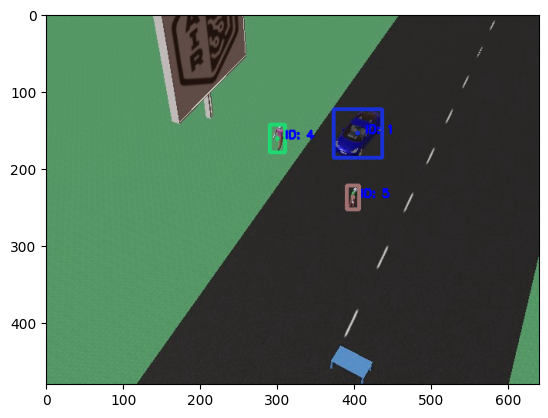

In [71]:
import cv2

for i in range(10):
    data = stream_receiver.get_data()
    drone_data = DroneData.from_json(data)
    camera_frame = drone_data.camera.frame
    
    result = model.predict(
        source=camera_frame,
        imgsz=camera_frame.shape[:2],
        classes=None,
        conf=0.3,
        iou=0.5,
        max_det=10,
        augment=False,
        agnostic_nms=True,
        device="cpu",
        half=False,
        verbose=False
    )[0]
    
    detections = []
    for result in result.boxes.data.tolist():    
        x1, y1, x2, y2, score, class_id = result
        x1 = int(x1)
        x2 = int(x2)
        y1 = int(y1)
        y2 = int(y2)
        class_id = int(class_id)    
        
        detections.append([x1, y1, x2, y2, score, class_id])
        
    tracker.update(camera_frame, detections)
    
for track in tracker.tracks:
    x1, y1, x2, y2 = track.to_tlbr()
    track_id = track.track_id
    class_id = track.class_id

    print(
        x1, y1, x2, y2, track_id, class_id
    )
    
    color = colors[track_id % len(colors)]

    cv2.rectangle(
        camera_frame,
        (int(x1), int(y1)),
        (int(x2), int(y2)),
        color,
        3
    )

    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    cv2.circle(
        camera_frame,
        (cx, cy),
        3,
        color,
        -1
    )

    cv2.putText(
        camera_frame,
        f"ID: {track_id}",
        (cx + 10, cy),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )

plt.imshow(camera_frame)

In [72]:
data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

image_width = drone_data.camera.width
image_height = drone_data.camera.height

fov_horizontal = drone_data.camera.fov
fov_vertical = 2 * math.atan(math.tan(fov_horizontal / 2) * (image_height / image_width))

gimbal_roll, gimbal_pitch, gimbal_yaw = gimbal_processor.get_data().quaternion.to_euler()
attitude = attitude_processor.get_data()

drone_roll = math.radians(attitude.roll)
drone_pitch = math.radians(attitude.pitch) 

global_position = global_position_processor.get_data()
drone_heading = math.radians(global_position.heading)

view_roll = gimbal_roll + drone_roll
view_pitch = gimbal_pitch + drone_pitch
view_yaw = gimbal_yaw + drone_heading

In [73]:
data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

cv2.imwrite("before.png", camera_frame)
plt.imshow(camera_frame)

True

In [74]:
for track in tracker.tracks:
    x1, y1, x2, y2 = track.to_tlbr()
    track_id = track.track_id
    class_id = track.class_id
    
    if model.names[class_id] == "car":
        detection_offset = geo_utils.detection_angles(geo_utils.find_center(x1, y1, x2, y2), (image_width, image_height), fov_horizontal, fov_vertical)
        
        direction_vector = geo_utils.calculate_direction_vector((view_roll, view_pitch, view_yaw), detection_offset)
    
        target_location = geo_utils.find_target_location(global_position, direction_vector, geospatial)
        
        print(target_location)
    

(-35.36312858760941, 149.16513228646548, 585)


In [75]:
mavlink_connection.gimbal.set_roi_location(*target_location)

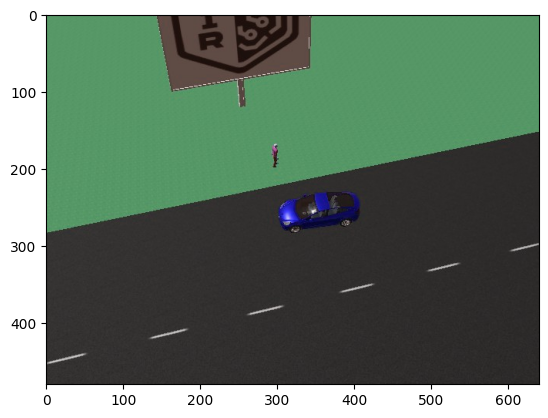

In [79]:
data = stream_receiver.get_data()
drone_data = DroneData.from_json(data)
camera_frame = drone_data.camera.frame

cv2.imwrite("after.png", camera_frame)
plt.imshow(camera_frame)

In [38]:
for i in range(100):
    data = stream_receiver.get_data()
    drone_data = DroneData.from_json(data)
    camera_frame = drone_data.camera.frame
    
    result = model.predict(
        source=camera_frame,
        imgsz=camera_frame.shape[:2],
        classes=None,
        conf=0.3,
        iou=0.5,
        max_det=10,
        augment=False,
        agnostic_nms=True,
        device="cpu",
        half=False,
        verbose=False
    )[0]
    
    detections = []
    for result in result.boxes.data.tolist():    
        x1, y1, x2, y2, score, class_id = result
        x1 = int(x1)
        x2 = int(x2)
        y1 = int(y1)
        y2 = int(y2)
        class_id = int(class_id)    
        
        detections.append([x1, y1, x2, y2, score, class_id])
        
    tracker.update(camera_frame, detections)
        
    image_width = drone_data.camera.width
    image_height = drone_data.camera.height
    
    fov_horizontal = drone_data.camera.fov
    fov_vertical = 2 * math.atan(math.tan(fov_horizontal / 2) * (image_height / image_width))
    
    gimbal_roll, gimbal_pitch, gimbal_yaw = gimbal_processor.get_data().quaternion.to_euler()
    attitude = attitude_processor.get_data()
    
    drone_roll = math.radians(attitude.roll)
    drone_pitch = math.radians(attitude.pitch) 
    
    global_position = global_position_processor.get_data()
    drone_heading = math.radians(global_position.heading)
    
    view_roll = gimbal_roll + drone_roll
    view_pitch = gimbal_pitch + drone_pitch
    view_yaw = gimbal_yaw + drone_heading
    
    for track in tracker.tracks:
        x1, y1, x2, y2 = track.to_tlbr()
        track_id = track.track_id
        class_id = track.class_id
        
        detection_offset = geo_utils.detection_angles(geo_utils.find_center(x1, y1, x2, y2), (image_width, image_height), fov_horizontal, fov_vertical)
        
        direction_vector = geo_utils.calculate_direction_vector((view_roll, view_pitch, view_yaw), detection_offset)
    
        target_location = geo_utils.find_target_location(global_position, direction_vector, geospatial)            
        
        print(track_id, target_location)

(-35.36311678569423, 149.1651363531946, 585)
(-35.363116773175, 149.165136303505, 585)
(-35.36315658421555, 149.1651798889546, 584)
(-35.363156517536915, 149.16517987092865, 584)


KeyboardInterrupt: 

In [49]:
from tqdm import tqdm

data_dictionary = {}

fps = 30
total_frames = 15 * fps

progress_bar = tqdm(total=total_frames)

for frame_number in range(total_frames):
    gimbal_roll, gimbal_pitch, gimbal_yaw = gimbal_processor.get_data().quaternion.to_euler()
    attitude = attitude_processor.get_data()
    drone_roll = math.radians(attitude.roll)
    drone_pitch = math.radians(attitude.pitch)
    global_position = global_position_processor.get_data()
    drone_heading = math.radians(global_position.heading)
    view_roll = gimbal_roll + drone_roll
    view_pitch = gimbal_pitch + drone_pitch
    view_yaw = gimbal_yaw + drone_heading
    
    data = stream_receiver.get_data()
    drone_data = DroneData.from_json(data)
    
    data_dictionary[frame_number] = {
        "view_roll": view_roll,
        "view_pitch": view_pitch,
        "view_yaw": view_yaw,
        "global_position": global_position,
        "camera": drone_data.camera
    }
    
    progress_bar.update(1)

100%|█████████▉| 448/450 [00:23<00:00, 18.99it/s]

100%|██████████| 450/450 [02:16<00:00,  3.70it/s]

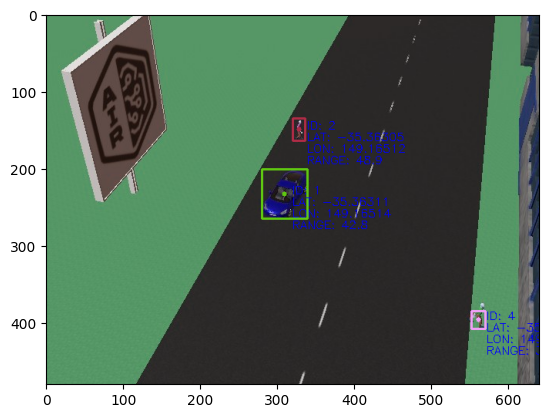

In [51]:
from tqdm import tqdm

progress_bar = tqdm(total=total_frames)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")  
out = cv2.VideoWriter("demo_video.mp4", fourcc, 30, (640, 480))

tracker = Tracker(
    feature_extractor=extractor,
    max_iou_distance=0.7,
    max_cosine_distance=0.7
)

for frame_number in range(total_frames):
    frame_data = data_dictionary[frame_number]

    camera = frame_data["camera"]
    
    result = model.predict(
        source=camera.frame,
        imgsz=camera.frame.shape[:2],
        classes=None,
        conf=0.3,
        iou=0.5,
        max_det=10,
        augment=False,
        agnostic_nms=True,
        device="cpu",
        half=False,
        verbose=False
    )[0]
    
    detections = []
    for result in result.boxes.data.tolist():    
        x1, y1, x2, y2, score, class_id = result
        x1 = int(x1)
        x2 = int(x2)
        y1 = int(y1)
        y2 = int(y2)
        class_id = int(class_id)    
        
        detections.append([x1, y1, x2, y2, score, class_id])
        
    tracker.update(camera_frame, detections)
    
    view_roll = frame_data["view_roll"]
    view_pitch = frame_data["view_pitch"]
    view_yaw = frame_data["view_yaw"]
    
    global_position = frame_data["global_position"]
    
    camera_frame = camera.frame.copy()
    for track in tracker.tracks:
        x1, y1, x2, y2 = track.to_tlbr()
        track_id = track.track_id
        class_id = track.class_id
        
        detection_offset = geo_utils.detection_angles(geo_utils.find_center(x1, y1, x2, y2), (image_width, image_height), fov_horizontal, fov_vertical)
        
        direction_vector = geo_utils.calculate_direction_vector((view_roll, view_pitch, view_yaw), detection_offset)
    
        target_location = geo_utils.find_target_location(global_position, direction_vector, geospatial)            
        
        color = colors[track_id % len(colors)]

        cv2.rectangle(
            camera_frame,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color,
            2
        )
    
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
    
        cv2.circle(
            camera_frame,
            (cx, cy),
            3,
            color,
            -1
        )
    
        cv2.putText(
            camera_frame,
            f"ID: {track_id}",
            (cx + 10, cy),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            1
        )
        
        distance = geo_utils.distance_between_locations(
            global_position.latitude, 
            global_position.longitude, 
            global_position.altitude, 
            *target_location)
        
        cv2.putText(
            camera_frame,
            f"LAT: {round(target_location[0], 5)}",
            (cx + 10, cy + 15),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            1
        )
        cv2.putText(
            camera_frame,
            f"LON: {round(target_location[1], 5)}",
            (cx + 10, cy + 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            1
        )
        cv2.putText(
            camera_frame,
            f"RANGE: {round(distance, 1)}",
            (cx + 10, cy + 45),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 0, 255),
            1
        )
    
    out.write(camera_frame)
    progress_bar.update(1)
    
out.release()

plt.imshow(camera_frame)

In [ ]:
from ballistics import projectile

# Пример использования
g = 9.81  # ускорение свободного падения
c = 0.3  # коэффициент сопротивления среды
dt = 0.01  # шаг времени
v0 = 0.1  # начальная скорость
theta = 120  # угол в градусах (вертикальный угол)
phi = 13  # угол в градусах (горизонтальный угол)
ro = 1.225  # плотность среды
area = 0.1  # площадь поперечного сечения объекта
mass = 1  # масса объекта
tr = True  # учет сопротивления среды
h0 = 30  # начальная высота
wind_speed = 3
wind_angle = 37

x, y, z, t = projectile(v0, h0, theta, phi, tr, ro, c, area, mass, wind_speed, wind_angle, dt)

print("Траектория:")
for i in range(len(x)):
    print(f"t = {i * dt} сек: x = {x[i]} м, y = {y[i]} м, z = {z[i]} м")
print(f"Время полета: {t} сек")

In [ ]:
import numpy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, label="Траєкторія", c='c')

ax.scatter(x[0], y[0], z[0], label="Дрон", c='b', marker='o', s=100)
ax.scatter(x[-1], y[-1], z[-1], label="Ціль", c='r', marker='*', s=300)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

offset = 10
x_max, x_min = max(x) + offset, min(x) - offset
y_max, y_min = max(y) + offset, min(y) - offset

ground_x = numpy.linspace(x_min, x_max, 1000)
ground_y = numpy.linspace(y_min, y_max, 1000)
ground_x, ground_y = numpy.meshgrid(ground_x, ground_y)
ground_z = numpy.zeros_like(ground_x)
ax.plot_surface(ground_x, ground_y, ground_z, color='green', alpha=0.5)

ax.legend()

plt.show()